### Importing utilities:

In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "datasets/HPA_challenge_2018/YNet_data_aws/yeast_Actin_v1.1.2/"
data_path = Path(PATH)

In [12]:
!ls datasets/HPA_challenge_2018/YNet_data_aws/yeast_Actin_v1.1.2/val

01_mmm1KO  02_WT      02_mmr1KO-mfb1KO	03_LatA-5uM  04_WT
01_num1KO  02_mfb1KO  03_CK666		03_WT


In [13]:
# CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'dnm1KO', 'fzo1KO', 'num1KO', 'mmm1KO', 'LatA5uM', 'CK666')
# NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = [2,224,224]

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

## Defining datasets:

In [14]:
def tfms_for_test(sz):
    test_norm = Normalize(stats=None, IntNorm=True)
    test_denorm = None
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [15]:
def get_data(path: str, sz, bs): # , num_workers=1
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs, num_workers = 8,
                                                                             test_name='test', test_with_labels=True,
                                                                             balance=True)
    augs = [RandomDihedral(),
            RandomRotate(90),
           ]
    
    tfms = tfms_with_IntNorm(sz, aug_tfms=augs, crop_type=CropType.CENTER, pad=sz[1]//8)
    test_tfms = tfms_for_test(sz)
    tfms += (test_tfms, )
    
    return create(tfms), lbl2index, lbl2index_test

In [16]:
data, lbl2idx, lbl2idx_test = get_data(PATH,SIZE,BATCH_SIZE)

Internal Normalization
val_crop is: 2
Internal Normalization
Using WeightedRandomSampler


In [17]:
lbl2idx_test

{'01_mfb1KO': [0, 0, 'mfb1KO'],
 '03_Eth': [1, 1, 'Eth'],
 '03_LatA-05uM': [2, 2, 'LatA-05uM'],
 '03_axl1KO': [3, 3, 'axl1KO'],
 '03_bud1KO': [4, 4, 'bud1KO']}

In [ ]:
x , y = next(iter(data.trn_dl))

In [ ]:
print(data.test_aug_dl.dataset.transform.tfms)

### Inspect loaded data:

Displaying the same image with and without normalization.

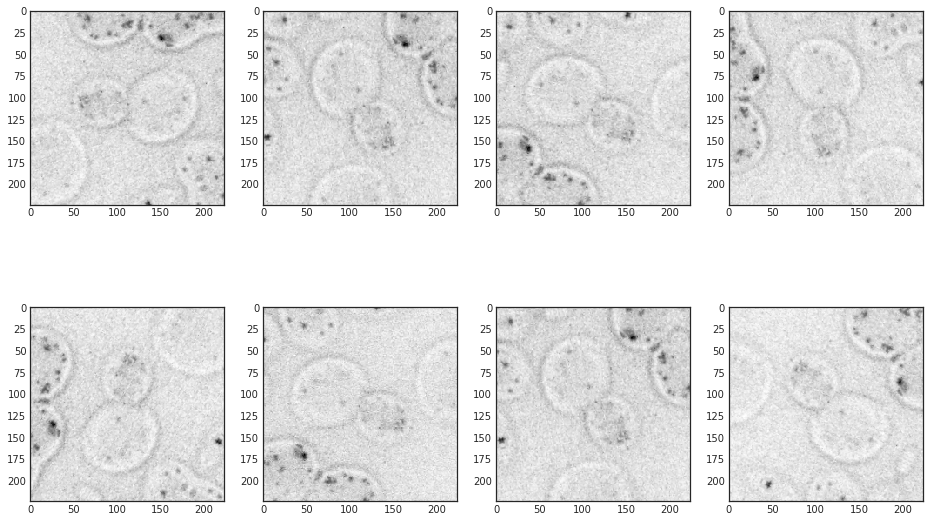

In [18]:
# print transformations
plt.style.use('seaborn-white')

c = 0
idx = 0
fig, ax = plt.subplots(2,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
    ax.imshow(np.sum(im, axis = 0))
#     ax.imshow(im[c])

In [ ]:
# print transformations
plt.style.use('seaborn-white')

c = 1
idx = 0
fig, ax = plt.subplots(2,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
#     ax.imshow(np.sum(im, axis = 0))
    ax.imshow(im[c])

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

    for b in range(0,len(dl)):
        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
xs, ys =  load_epoch()

In [ ]:
import seaborn as sns

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 8))

for i in [2,3]:
    
    xs_clss = xs[ys == i] 
    xs_sub = xs_clss[:100,...]
    xs_sub = xs_sub.reshape(-1,2,50176)
    
    ch0, ch1 = np.ravel(xs_sub[:,0]), np.ravel(xs_sub[:,1])
    print(ch1.shape)

    sns.kdeplot(ch0, ax = axarr[0], label = data.classes[i])
    sns.kdeplot(ch1, ax = axarr[1], label = data.classes[i])
    
# axarr[0].set_xlim(-12,12);
# axarr[1].set_xlim(-10,18);   
# axarr[0].set_ylim(0,0.8);
# axarr[1].set_ylim(0,1.8);
axarr[1].legend()

In [ ]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
print(len(data.test_dl.dataset.y))

# Training setup

In [19]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

Defining network architecture. 

In [20]:
arch = resnet18_c
# arch = resnet34_c

In [21]:
learn = ConvLearner.pretrained(arch, data, ps=0.25, opt_fn=optim.Adam, pretrained=False)

In [22]:
learn.unfreeze()

In [ ]:
learn.summary()

In [28]:
wd=1e-5 # weight-decay/L2 regularization 

In [23]:
learn.lr_find2(1e-10)

EPOCH 0 ---------------------------------------- STEP 0   
EPOCH 1 ---------------------------------------- STEP 1   
EPOCH 2 ---------------------------------------- STEP 2   


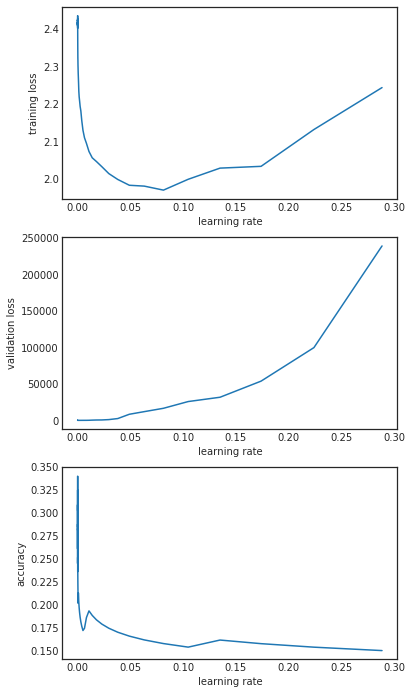

In [24]:
learn.sched.plot()

In [26]:
lbl2idx

{'01_mmm1KO': [0, 0, 'mmm1KO'],
 '01_num1KO': [1, 1, 'num1KO'],
 '02_WT': [2, 2, 'WT'],
 '02_mfb1KO': [3, 3, 'mfb1KO'],
 '02_mmr1KO-mfb1KO': [4, 4, 'mmr1KO-mfb1KO'],
 '03_CK666': [5, 5, 'CK666'],
 '03_LatA-5uM': [6, 6, 'LatA-5uM'],
 '03_WT': [7, 2, 'WT'],
 '04_WT': [8, 2, 'WT']}

In [29]:
%time learn.fit(1e-3, 8, cycle_len=1, wds=wd, use_wd_sched=True, best_save_name='YNet_Actin_v1.1.2_Res18_v01')

EPOCH 0 ---------------------------------------- STEP 3   
epoch      trn_loss   val_loss   accuracy   
    0      1.607856   1.608004   0.334921  
EPOCH 1 ---------------------------------------- STEP 4   
    1      1.359503   1.302618   0.526984  
EPOCH 2 ---------------------------------------- STEP 5   
    2      1.240964   1.205553   0.528571  
EPOCH 3 ---------------------------------------- STEP 6   
    3      1.073837   1.029309   0.57619   
EPOCH 4 ---------------------------------------- STEP 7    
    4      0.944137   1.081975   0.587302  
EPOCH 5 ---------------------------------------- STEP 8    
    5      0.84096    0.888794   0.646032  
EPOCH 6 ---------------------------------------- STEP 9    
    6      0.801688   1.022555   0.563492  
EPOCH 7 ---------------------------------------- STEP 10   
    7      0.703525   0.757483   0.677778  
creating log-files...
log-files saved to: datasets/HPA_challenge_2018/YNet_data_aws/yeast_Actin_v1.1.2/
appending existing log-

[array([0.75748]), 0.677777780237652]

In [30]:
%time learn.fit(1e-3, 1, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='YNet_Actin_v1.1.2_Res18_v1')

EPOCH 0 ---------------------------------------- STEP 11   
epoch      trn_loss   val_loss   accuracy   
    0      0.636488   4.030541   0.295238  
EPOCH 1 ---------------------------------------- STEP 12   
    1      0.733568   2.271177   0.309524  
EPOCH 2 ---------------------------------------- STEP 13   
    2      0.678419   2.219715   0.352381  
EPOCH 3 ---------------------------------------- STEP 14   
    3      0.629406   2.4301     0.465079  
EPOCH 4 ---------------------------------------- STEP 15   
    4      0.631388   1.11938    0.571429  
EPOCH 5 ---------------------------------------- STEP 16   
    5      0.579054   0.798405   0.649206  
EPOCH 6 ---------------------------------------- STEP 17   
    6      0.528319   0.582151   0.757143  
EPOCH 7 ---------------------------------------- STEP 18   
    7      0.472512   0.68421    0.707937  
appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/YNet_data_aws/yeast_Actin_v1.1.2/
appending

[array([0.68421]), 0.707936507936508]

In [31]:
learn.load('YNet_Actin_v1.1.2_Res18_v1')

In [32]:
%time learn.fit(1e-3, 3, cycle_len=8, cycle_mult =2, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='YNet_Actin_v1.1.2_Res18_v2')

EPOCH 0 ---------------------------------------- STEP 19   
epoch      trn_loss   val_loss   accuracy   
    0      0.522412   1.79964    0.463492  
EPOCH 1 ---------------------------------------- STEP 20   
    1      0.59855    1.147178   0.626984  
EPOCH 2 ---------------------------------------- STEP 21   
    2      0.576159   2.319661   0.536508  
EPOCH 3 ---------------------------------------- STEP 22   
    3      0.51779    0.687912   0.712698  
EPOCH 4 ---------------------------------------- STEP 23   
    4      0.47305    1.090677   0.64127   
EPOCH 5 ---------------------------------------- STEP 24   
    5      0.435723   1.055643   0.626984  
EPOCH 6 ---------------------------------------- STEP 25   
    6      0.41896    0.600467   0.725397  
EPOCH 7 ---------------------------------------- STEP 26   
    7      0.401572   0.545063   0.769841  
EPOCH 8 ---------------------------------------- STEP 27   
    8      0.383676   1.304981   0.58254   
EPOCH 9 -----------

[array([0.46314]), 0.8206349215810261]

In [33]:
learn.load('YNet_Actin_v1.1.2_Res18_v2')

In [34]:
%time learn.fit(5e-4, 3, cycle_len=16, cycle_mult =2, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85), best_save_name='YNet_Actin_v1.1.2_Res18_v3')

EPOCH 0 ---------------------------------------- STEP 75   
epoch      trn_loss   val_loss   accuracy   
    0      0.250903   0.416313   0.826984  
EPOCH 1 ---------------------------------------- STEP 76   
    1      0.245918   0.958471   0.730159  
EPOCH 2 ---------------------------------------- STEP 77   
    2      0.287043   0.58161    0.787302  
EPOCH 3 ---------------------------------------- STEP 78   
    3      0.309277   0.802463   0.707937  
EPOCH 4 ---------------------------------------- STEP 79   
    4      0.310073   0.766299   0.747619  
EPOCH 5 ---------------------------------------- STEP 80   
    5      0.293767   0.461954   0.793651  
EPOCH 6 ---------------------------------------- STEP 81   
    6      0.290194   0.513871   0.804762  
EPOCH 7 ---------------------------------------- STEP 82   
    7      0.300151   0.716318   0.760317  
EPOCH 8 ---------------------------------------- STEP 83   
    8      0.273331   0.473562   0.801587  
EPOCH 9 -----------

[array([0.38695]), 0.8682539682539683]

In [ ]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

#### Run some more cylces - error & accuracy should continuously improve

Note: cycle len = number of epochs per cycle

In [ ]:
learn.freeze_to(2)

In [ ]:
adjust = {0:22,
          1:14,
#           2:22,
          3:3,
          4:3,
         5:14,
         6:14
         }

# use_clr=(20,8, 0.95, 0.85),
%time learn.fit(1e-3, 1, cycle_len=8, wds=wd, use_wd_sched=True, adjust_class=adjust, best_save_name='YNet_v11.1_ResNet34_dihedral_ps025_IntNorm_rot90_rGauss_balanced_86_FT_mmr1')

## Analysis/Model evaluation

This is one of the major areas that needs improvement in our workflow. The tools we have so far (confusion matrix and manual inpsection of images) are essential but definitely not sufficient to ensure that our model learns something biologicaly relevant. Ideas are welcome!

### ...after training 

In [ ]:
## Load model:
learn.load('YNet_Actin_v1.1_Res18_v3')
learn.freeze_to(3)

In [35]:
log_preds, y = learn.TTA(8) # run predictions with TTA

### Cross_validation evaluation

[[ 66  10   0   1   0   0   0]
 [  3  59   0   0   0   0   0]
 [  1   1 177   2   2   0   0]
 [  0   0  10  54  14   0   0]
 [  0   0  23  13  54   0   0]
 [  0   0   0   0   0  69   0]
 [  0   0   0   0   0   1  70]]


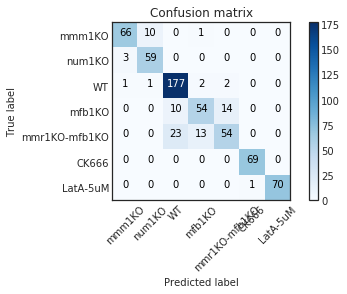

In [36]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [37]:
# targ_names = ['mmm1KO', 'num1KO', 'WT', 'mfb1KO', 'mmr1KO', 'CK666', 'LatA', 'dnm1KO', 'fzo1KO']

In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(accuracy_score(preds, y))

print(classification_report(preds, y, target_names=data.classes))

0.8714285714285714
               precision    recall  f1-score   support

       mmm1KO       0.94      0.86      0.90        77
       num1KO       0.84      0.95      0.89        62
           WT       0.84      0.97      0.90       183
       mfb1KO       0.77      0.69      0.73        78
mmr1KO-mfb1KO       0.77      0.60      0.68        90
        CK666       0.99      1.00      0.99        69
     LatA-5uM       1.00      0.99      0.99        71

    micro avg       0.87      0.87      0.87       630
    macro avg       0.88      0.86      0.87       630
 weighted avg       0.87      0.87      0.87       630



In [ ]:
preds_noAct = []
y_noAct = []
for i in [2,3,4,0,1,7,8]:
    preds_noAct.extend(preds[y == i])
    y_noAct.extend(y[y==i])
    
print(accuracy_score(preds_noAct, y_noAct))
print(classification_report(preds_noAct, y_noAct, target_names=['WT', 'mfb1KO', 'mmr1KO', 'mmm1KO', 'num1KO', 'dnm1KO', 'fzo1KO']))

In [ ]:
len(y_noAct), len(preds_noAct)

## Test-set eval

In [ ]:
learn.models.model

In [41]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [42]:
embeddings = get_embeddings('14')

In [43]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(1814, 512)
(630, 512)
(1344, 512)
(1814,)
(630,)
(1344,)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# running PCA on embeddings
pca = []
n_components = 50
pca = PCA(n_components)

trn_pca_result = pca.fit_transform(embs_trn)
val_pca_result = pca.transform(embs_val)
test_pca_result = pca.transform(embs_test)

In [ ]:
#plotting compenent-wise cumulative explained variance (for PCA)

plt.plot(range(n_components), pca.explained_variance_ratio_)
plt.plot(range(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In [ ]:
# running TSNE on embeddings

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs_trn)

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(9):
    PCA_cls = trn_pca_result[y_trn == i]
    TSNE_cls = tsne_results[y_trn == i]
    
    axarr[0].scatter(PCA_cls[:,compA], PCA_cls[:,compB], label = data.classes[i], s = 5)
    axarr[1].scatter(TSNE_cls[:,compA], TSNE_cls[:,compB], label = data.classes[i], s =5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_PCA_cls = trn_pca_result[y_trn == i]
    val_PCA_cls = val_pca_result[y_val == i]

    axarr[0].scatter(trn_PCA_cls[:,compA], trn_PCA_cls[:,compB], label = data.classes[i])
    axarr[1].scatter(val_PCA_cls[:,compA], val_PCA_cls[:,compB], label = data.classes[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
print(lbl2idx_test)

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_PCA_cls = trn_pca_result[y_trn == i]

    axarr[0].scatter(trn_PCA_cls[:,compA], trn_PCA_cls[:,compB], label = data.classes[i])
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[0].set_xlim(-15,45)
    axarr[0].set_ylim(-20,20)
    
for i in [0,1,3]:
    test_PCA_cls = test_pca_result[y_test == i]
    axarr[1].scatter(test_PCA_cls[:,compA], test_PCA_cls[:,compB], label = list(lbl2idx_test.keys())[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[1].set_xlim(-15,45)
    axarr[1].set_ylim(-20,20)


In [ ]:
list(lbl2idx_test.keys())[0]

In [ ]:
# Generate 3D TSNE space from PCA of embeddings

tsne3D = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, learning_rate=50.0)
PCA2tSNE_results_3D = tsne3D.fit_transform(embs)

In [ ]:
tsne3D

In [ ]:
from mpl_toolkits import mplot3d

# magic command to make plots interactive.
# restart kernel if you want to switch to e.g. %matplotlib inline
%matplotlib notebook

In [ ]:
# 3D plotting - very slow interactivity atm...

fig = plt.figure()
ax = plt.axes(projection='3d')

compA = 0
compB = 1
compC = 2

for i in range(10):
    clss = PCA2tSNE_results_3D[y == i]
    cls_C = clss[0:500,:]
    ax.scatter3D(cls_C[:,compA], cls_C[:,compB], cls_C[:,compC])

In [39]:
import umap

In [44]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=30,
                      min_dist=1,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

In [45]:
!ls datasets/HPA_challenge_2018/YNet_data_aws/yeast_Actin_v1.1.1/train

ls: cannot access 'datasets/HPA_challenge_2018/YNet_data_aws/yeast_Actin_v1.1.1/train': No such file or directory


In [48]:
lbl2idx

{'01_mmm1KO': [0, 0, 'mmm1KO'],
 '01_num1KO': [1, 1, 'num1KO'],
 '02_WT': [2, 2, 'WT'],
 '02_mfb1KO': [3, 3, 'mfb1KO'],
 '02_mmr1KO-mfb1KO': [4, 4, 'mmr1KO-mfb1KO'],
 '03_CK666': [5, 5, 'CK666'],
 '03_LatA-5uM': [6, 6, 'LatA-5uM'],
 '03_WT': [7, 2, 'WT'],
 '04_WT': [8, 2, 'WT']}

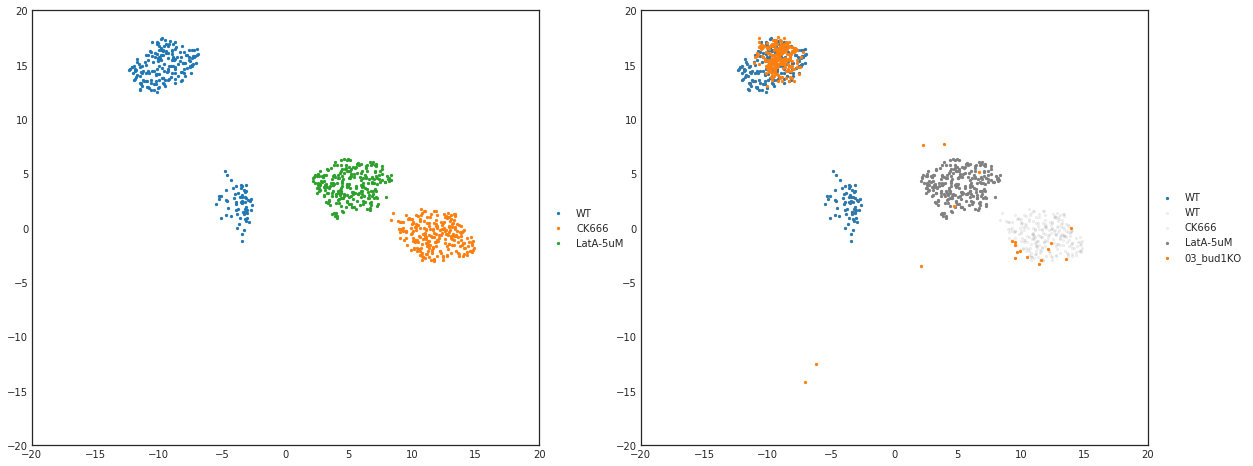

In [68]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in [2,5,6]:
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 2:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    if i == 6:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c='gray')
    else:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c='gray', alpha=.1)

    axarr[0].set_xlim(-20,20)
    axarr[0].set_ylim(-20,20)
    
for i in [4]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], label = list(lbl2idx_test.keys())[i], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[1].set_xlim(-20,20)
    axarr[1].set_ylim(-20,20)


In [53]:
lbl2idx_test

{'01_mfb1KO': [0, 0, 'mfb1KO'],
 '03_Eth': [1, 1, 'Eth'],
 '03_LatA-05uM': [2, 2, 'LatA-05uM'],
 '03_axl1KO': [3, 3, 'axl1KO'],
 '03_bud1KO': [4, 4, 'bud1KO']}

In [ ]:
UMAP_WT = UMAP_trn[y_trn == 2]

In [ ]:
plt.scatter(UMAP_WT[:,0], UMAP_WT[:,1], s = 5)

In [ ]:
len(data.trn_ds.fnames) + len(data.val_ds.fnames)

In [ ]:
# Specify data

x = UMAP_WT[:,0]
y = UMAP_WT[:,1]
data1 = UMAP_WT

with sns.axes_style('white'):
    pal = sns.dark_palette("palegreen", as_cmap=True)
    sns.jointplot(x, y, kind='kde', shade=False, cmap=pal, color='k').plot_joint(plt.scatter, s=18, color='k')
    
#     , xlim=(-1.e3, 1e8), ylim=(-0.2e8, 1e8)


In [ ]:
lbl2idx_test)

### Visualizing train and test datasets as exposed by dataloader

### Inference

In [ ]:
lbl2idx

In [ ]:
lbl2idx_test

In [ ]:
# test_log_preds, test_targs = learn.predict_with_targs('test')
test_log_preds, test_targs = learn.TTA(is_test=True, n_aug=8)
test_log_preds = np.mean(test_log_preds, axis=0)
testprobs = np.exp(test_log_preds)
test_preds = np.argmax(testprobs, axis=1)

In [ ]:
test_robust = []
y_test_robust = []
for i in [0,1,2]:
    test_robust.extend(test_preds[test_targs == i])
    y_test_robust.extend(test_targs[test_targs==i])

In [ ]:
y_test_robust = np.array(y_test_robust)
y_test_robust[y_test_robust == 2] = 4
y_test_robust[y_test_robust == 1] = 3
y_test_robust[y_test_robust == 0] = 2

In [ ]:
# np.array(test_robust)

cm = confusion_matrix(test_robust,y_test_robust)
plot_confusion_matrix(cm, ['WT', 'mfb1KO', 'mmr1KO'])

In [ ]:
print(accuracy_score(test_robust, y_test_robust))
# print(classification_report(test_robust, y_test_robust, target_names=['WT', 'mfb1KO', 'mmr1KO']))

In [ ]:
preds_dict

In [ ]:
# make predictions dictionary

h = 0
preds_dict = {}
for i, key in enumerate(lbl2idx_test.keys()):
    l = h
    h = h + list(data2.test_dl.dataset.src_idx).count(i)
    preds_dict[key] = list(test_preds[l:h])
    print(f"{key} predictions ready ({h - l} elements)")

In [ ]:
preds_rel = {}
for key in preds_dict.keys():
    print(key)
    val = {cls: preds_dict[key].count(i)/len(preds_dict[key]) for i, cls in enumerate(data2.classes)}
    preds_rel[key]= val

In [ ]:
def plot_test_preds(targets, preds_rel):
    
    if not isinstance(targets, list):
        targets = [targets]
        
    x = math.ceil((int(len(targets)) /2)) # dynamic scaling of GridSpec
    sz = 4 * x # dynamic scaling of figuresize
    
    # plotting:
    plt.figure(figsize=(12,sz))
    gs1 = plt.GridSpec(x,2)
    gs1.update(wspace = 0.4)

    for i, targ in enumerate(targets):
        to_plot = [preds_rel[targ][key] for key in data.classes] # extracting data
        ax1 = plt.subplot(gs1[i])
        ax1.barh(data.classes, to_plot)
        ax1.set_title(targ)
        ax1.set_xlim(0,1)
    
    plt.show()

In [ ]:
test_classes = list(lbl2idx_test.keys())

plot_test_preds(test_classes, preds_rel)
# plot_test_preds(['01_WT', '03_WT', '03_fzo1KO', '01_mfb1KO'], preds_rel)
# plot_test_preds(['01_WT', '01_mfb1KO', '01_mmr1KO'], preds_rel)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highest probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x, _ in enumerate(corr_lbl)]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

In [ ]:
lbl2idx_

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[0:5]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified CK666")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(4, True), "Most correctly classified LatA")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(5, True), "Most correctly classified dnnm1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(6, True), "Most correctly classified fzo1KO")

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[1:5] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

In [ ]:
lbl2idx_